# Airfoil experiments
All data is available in the repository

In [1]:
import sys
sys.path.append('../python')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from machine_learning import *
from notebook_network_size import find_best_network_size_notebook, try_best_network_sizes
from train_single_network import train_single_network
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


# Setup

In [2]:
qmc_points = np.loadtxt('../sobol_6_8000.txt')
qmc_points = qmc_points[1:].reshape((8000,6))

large_qmc_points = np.loadtxt('../sobol_6_131072.txt')
all_points = qmc_points.copy()
forces = np.array(np.loadtxt('../force_6_params.dat'))


N = min(qmc_points.shape[0], forces.shape[0])
qmc_points = qmc_points[:N,:]
forces  = forces[:N,:]


input_size=6
train_size=128
validation_size=128

epochs = 5

airfoils_network = [12, 12, 10, 12, 10, 12, 10, 10, 12,1]


# Network sizes

Find the optimal network size


Config 4 x 6 ([0 x 0] / [1 x 1])
Training and postprocessing took: 3372.4536390304565 seconds (56.20756065050761 minutes) (0.9367926775084602 hours)
all_errors_map[Prediction error]=\ 
[[0.01812623]]


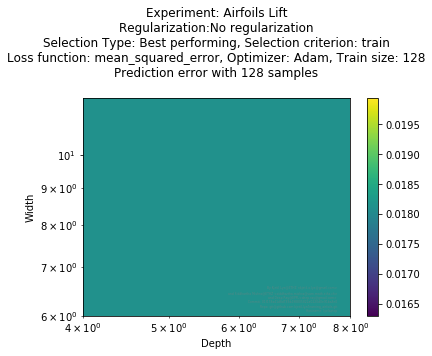

Memory usage: 518040
all_errors_map[Error mean]=\ 
[[0.00034627]]


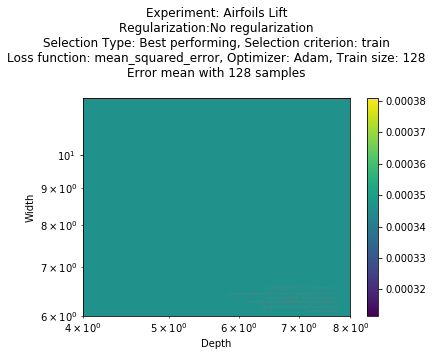

Memory usage: 518040
all_errors_map[Error variance]=\ 
[[0.0046528]]


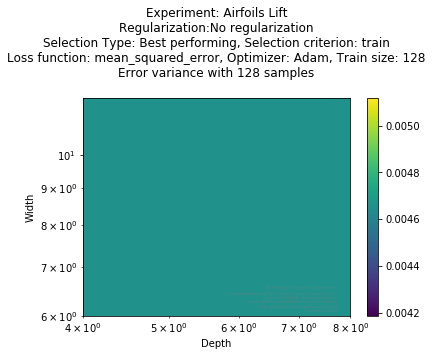

Memory usage: 518040
all_errors_map[Wasserstein]=\ 
[[0.00446625]]


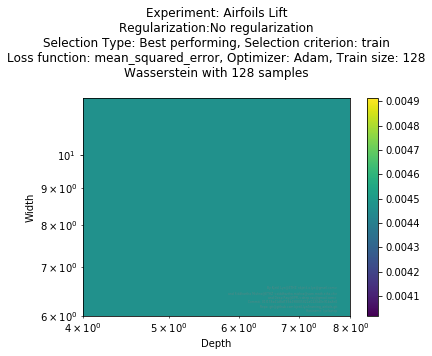

Memory usage: 518040
all_errors_map[Selection error (train)]=\ 
[[0.00684049]]


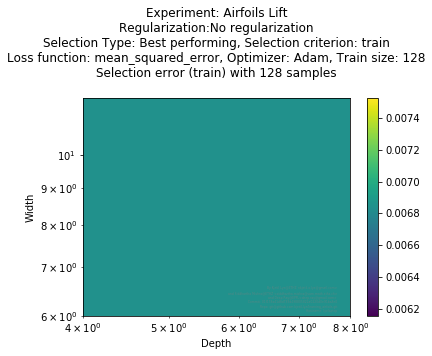

Memory usage: 518040


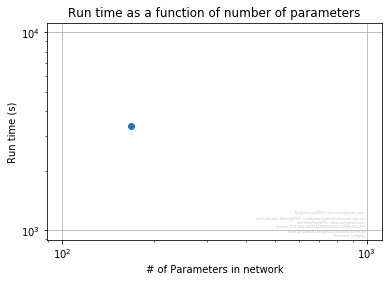

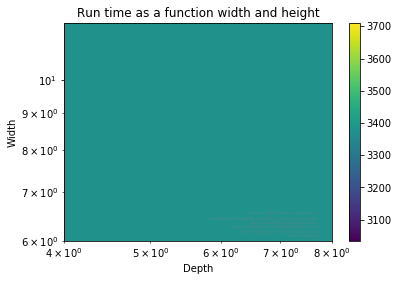

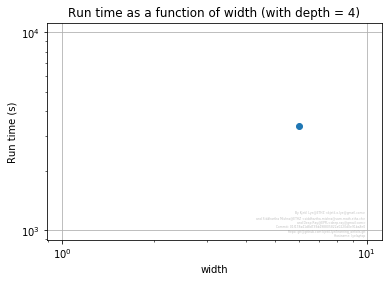

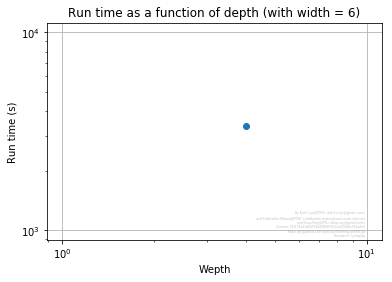

Config 4 x 6 ([0 x 0] / [1 x 1])
Training and postprocessing took: 3622.8150329589844 seconds (60.38025054931641 minutes) (1.0063375091552735 hours)
all_errors_map[Prediction error]=\ 
[[0.01869699]]


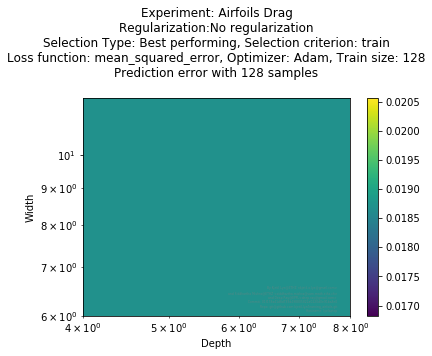

Memory usage: 669724
all_errors_map[Error mean]=\ 
[[0.00078975]]


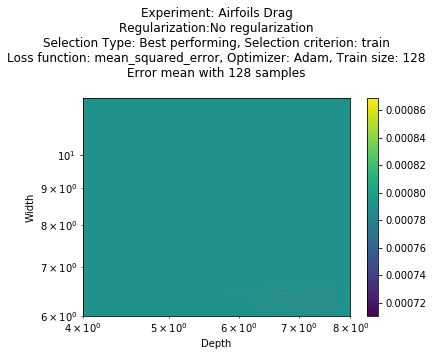

Memory usage: 669724
all_errors_map[Error variance]=\ 
[[0.0044038]]


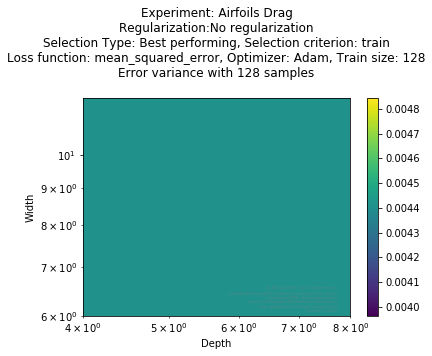

Memory usage: 669724
all_errors_map[Wasserstein]=\ 
[[0.00033146]]


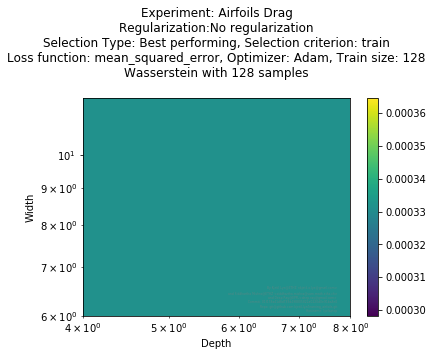

Memory usage: 669724
all_errors_map[Selection error (train)]=\ 
[[0.00025034]]


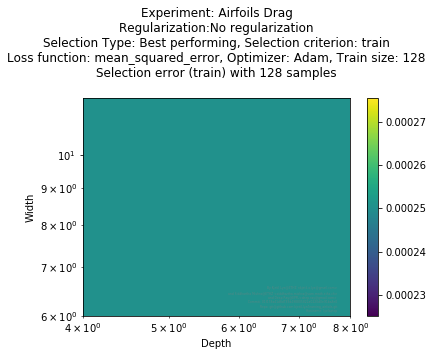

Memory usage: 669724


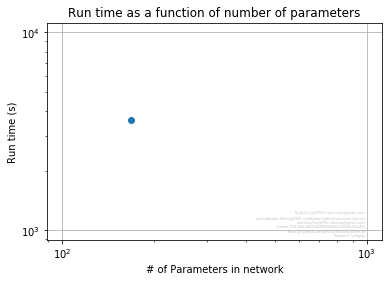

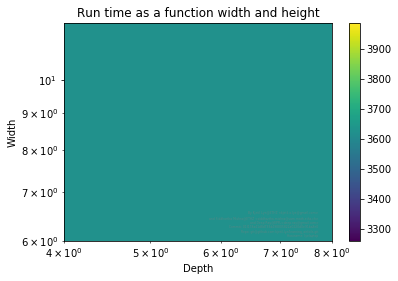

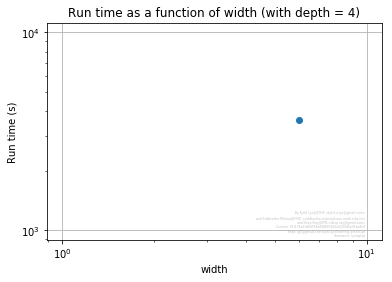

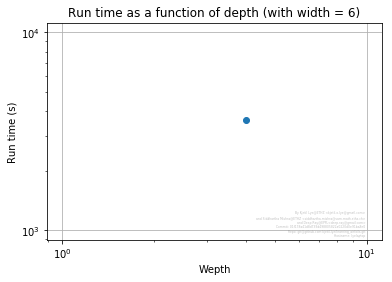

In [3]:
force_names=['Lift', 'Drag']

for n, force_name in enumerate(force_names):
    display(HTML("<h1>%s</h1>"% force_name))
    try_best_network_sizes(parameters=qmc_points, 
                           samples=forces[:,n+1], 
                           base_title='Airfoils %s' % force_name,
                          epochs=epochs)

# One network per variable


Training took 1.4374706745147705 seconds


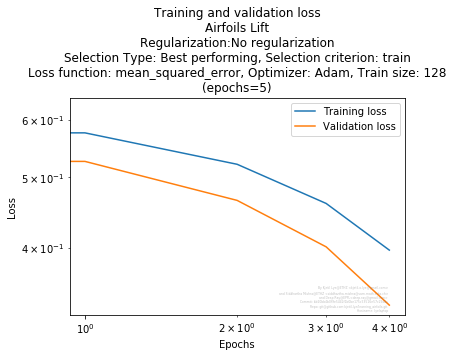


Training took 1.3988821506500244 seconds


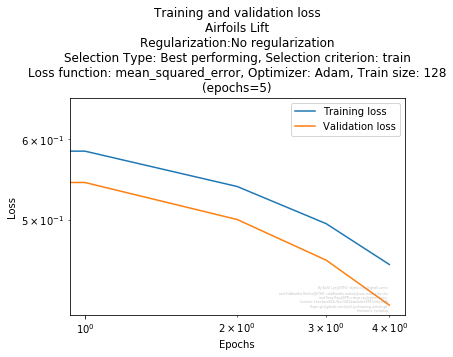


Training took 1.7982916831970215 seconds


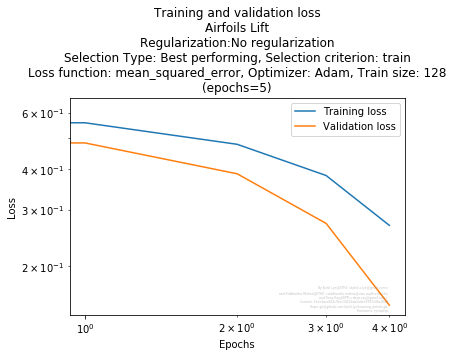


Training took 1.410154104232788 seconds


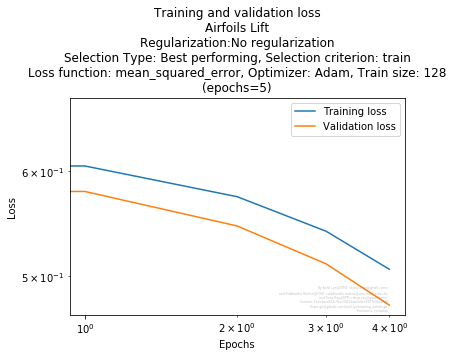


Training took 1.5083444118499756 seconds


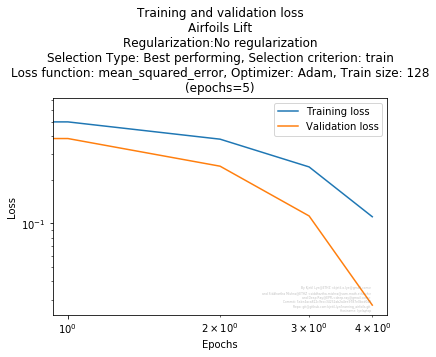

Best network index: 4
Total learning time took: 70 s


########################################################################################
#AirfoilsLift_Noregularization_Bestperforming_train_mean_squared_error_Adam_128_network#
########################################################################################
-----  ----  ----------
Layer  Size  Parameters
0      12    84
1      12    156
2      10    130
3      12    132
4      10    130
5      12    132
6      10    130
7      10    110
8      12    132
9      1     13
Sum          1149
-----  ----  ----------
########################################################################################


Training took 15.39756155014038 seconds


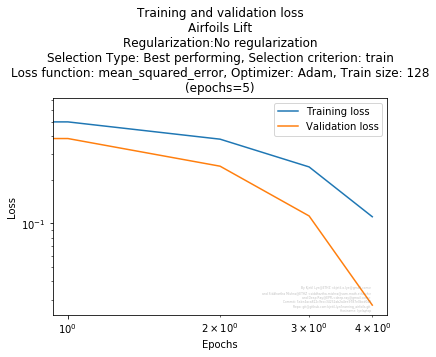

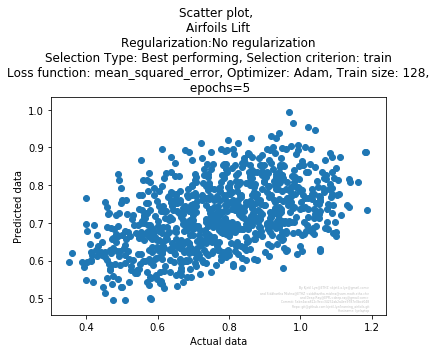

Number of parameters: 1149


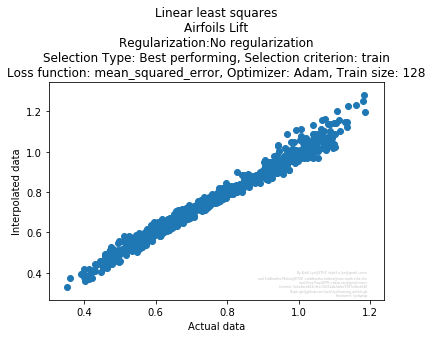

(1001,)
(1001, 6)


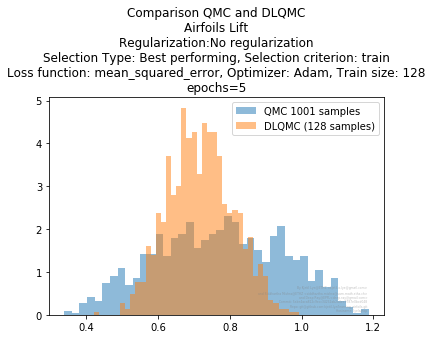

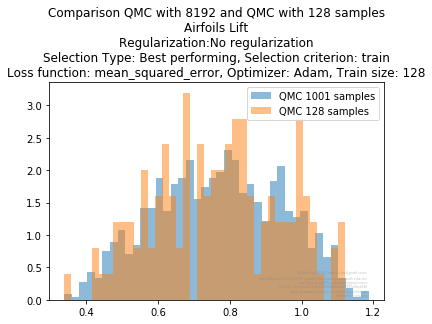

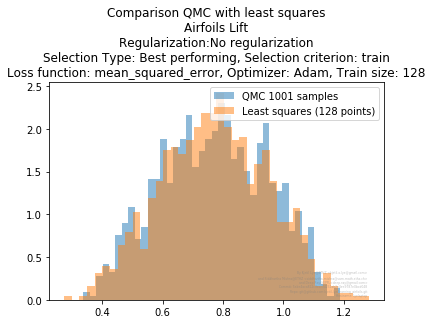

Computing large integration points


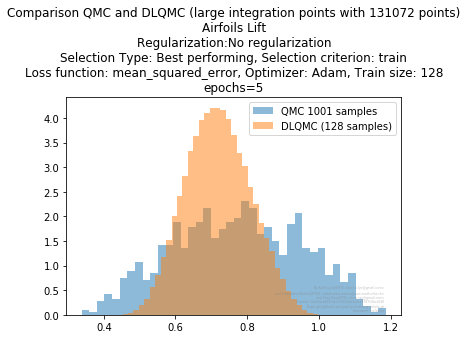

Memory usage: 539840
Memory usage: 539840


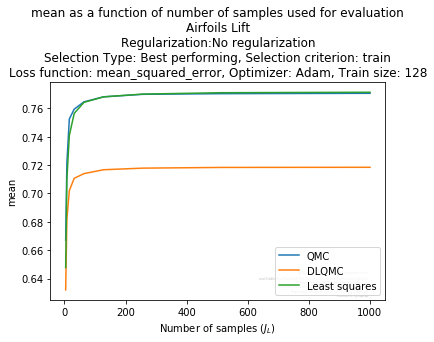

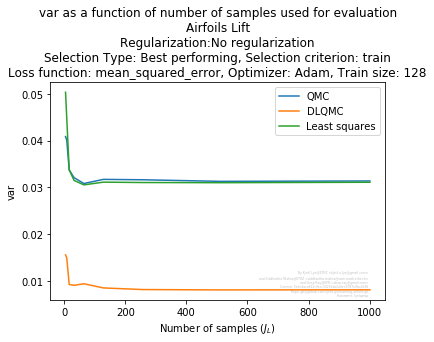

Memory usage: 539840


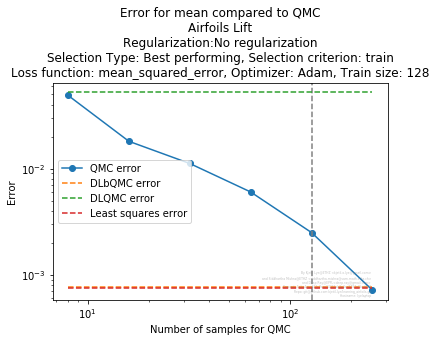

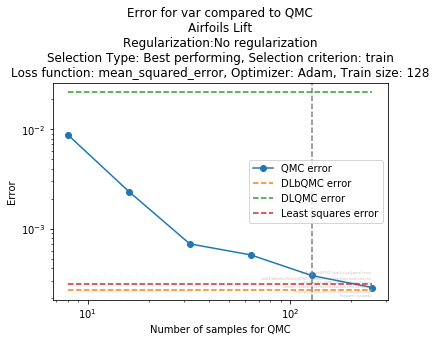

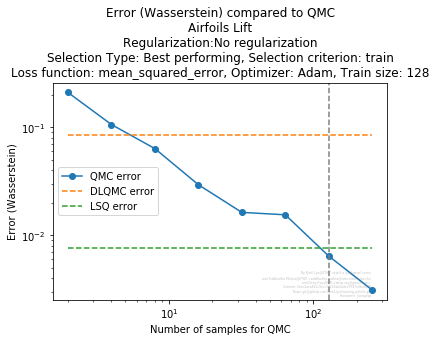

Trying with a large number of QMC samples 131072


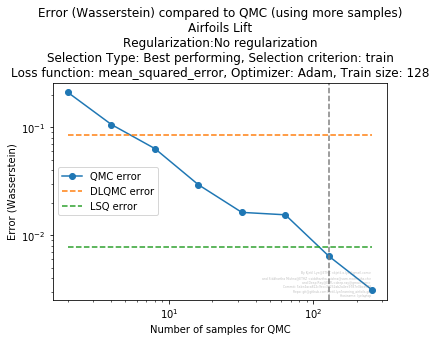

{"main_error": 0.06766527397370037, "variance_error": 0.742990265768091, "wasserstein_error": 0.08537864251536156, "selection_error": 1.857182264328003, "prediction_error": 0.22318448270040048}


##############################################################################################
#AirfoilsLift_Noregularization_Bestperforming_train_mean_squared_error_Adam_128_speedup_table#
##############################################################################################
  -------  -------  -------------------  --------------------  ------------------  ------------------  -----------------  ------------------
  QMC 128  QMC 128  DLQMC                DLQMC                 DLbQMC              DLbQMC              Least squares      Least squares
  mean     var      mean                 var                   mean                var                 mean               var
Airfoils Lift
Regularization:No regularization
Selection Type: Best performing, Selection criterion: train
Loss func


Training took 1.6569981575012207 seconds


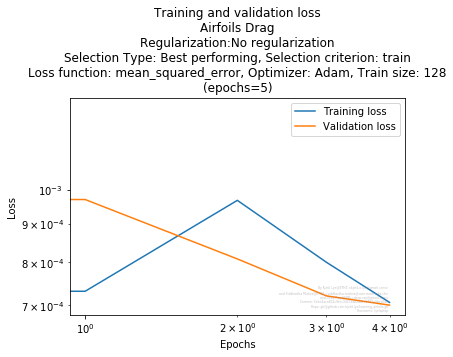


Training took 1.7205452919006348 seconds


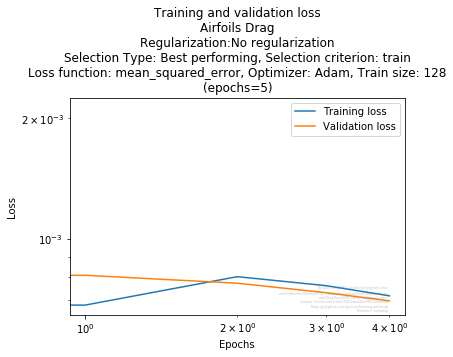


Training took 2.3783881664276123 seconds


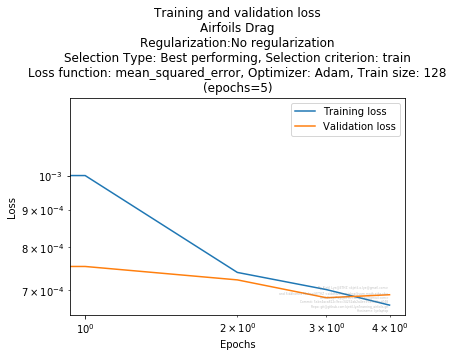


Training took 2.360700845718384 seconds


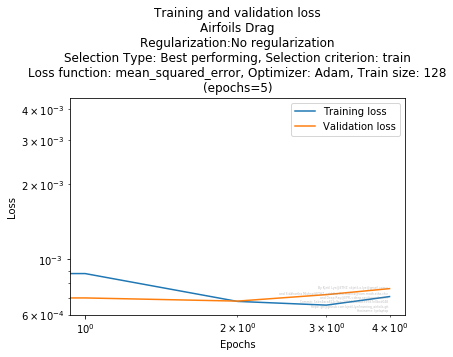


Training took 3.305530548095703 seconds


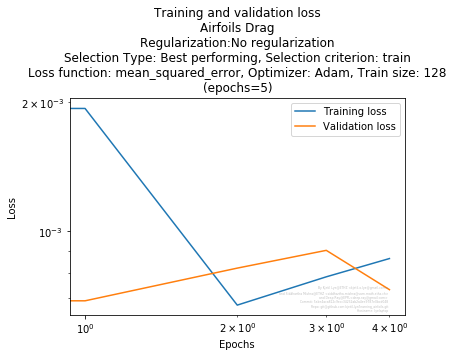

Best network index: 2
Total learning time took: 90 s


########################################################################################
#AirfoilsDrag_Noregularization_Bestperforming_train_mean_squared_error_Adam_128_network#
########################################################################################
-----  ----  ----------
Layer  Size  Parameters
0      12    84
1      12    156
2      10    130
3      12    132
4      10    130
5      12    132
6      10    130
7      10    110
8      12    132
9      1     13
Sum          1149
-----  ----  ----------
########################################################################################


Training took 20.663703441619873 seconds


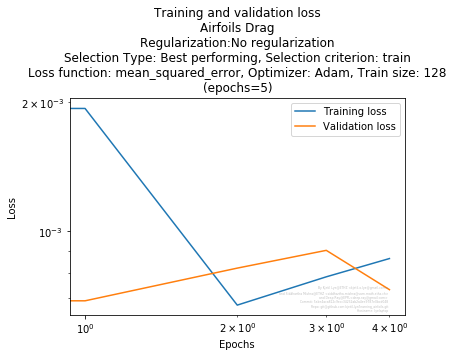

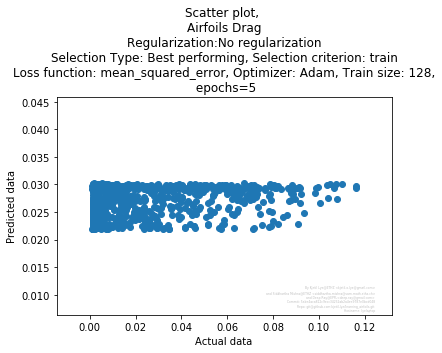

Number of parameters: 1149


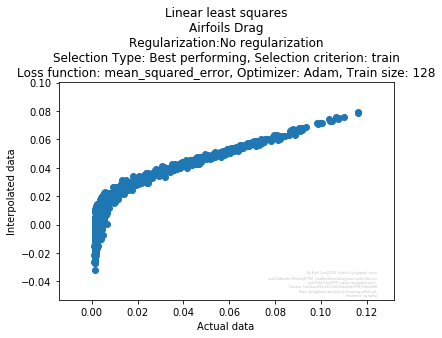

(1001,)
(1001, 6)


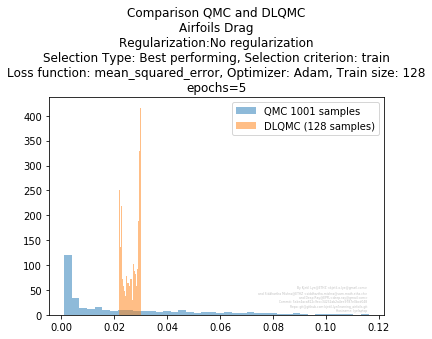

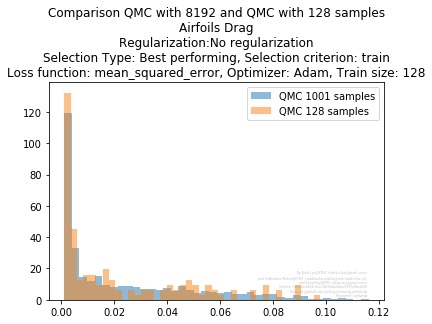

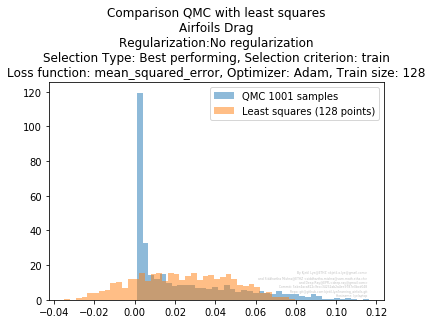

Computing large integration points


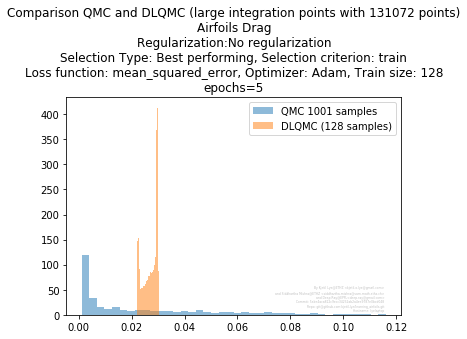

Memory usage: 852344
Memory usage: 852344


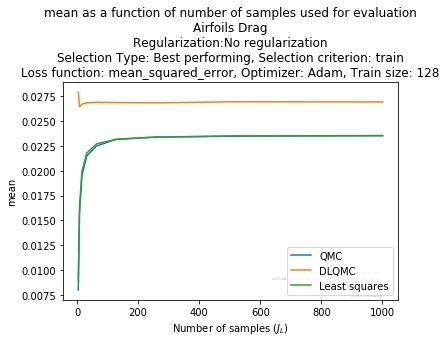

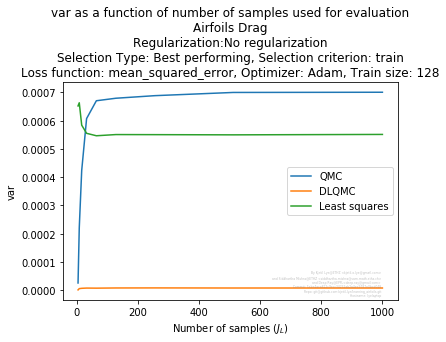

Memory usage: 852344


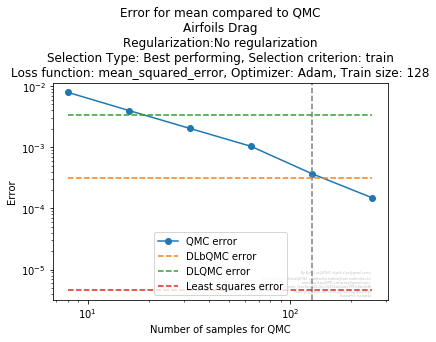

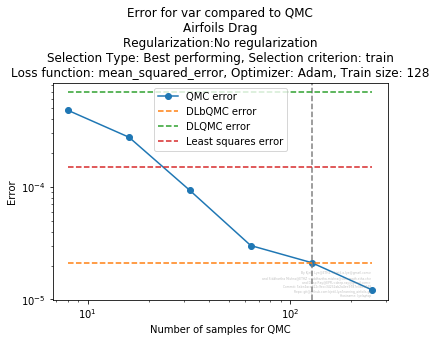

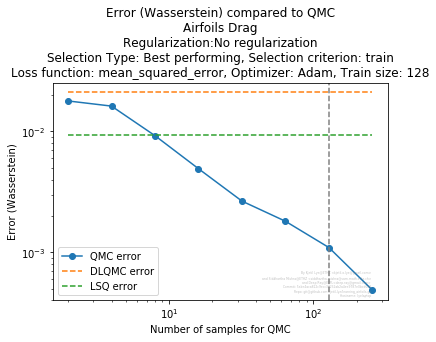

Trying with a large number of QMC samples 131072


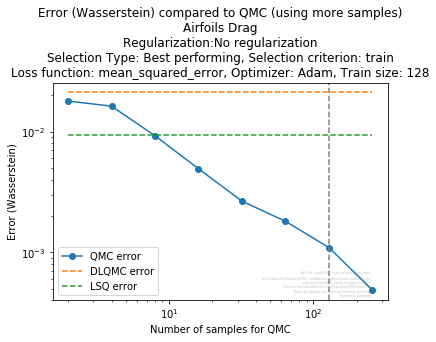

{"main_error": 0.14437685332132474, "variance_error": 0.9887260927717592, "wasserstein_error": 0.021050822088468844, "selection_error": 0.004346565634477884, "prediction_error": 0.7968541524269929}


##############################################################################################
#AirfoilsDrag_Noregularization_Bestperforming_train_mean_squared_error_Adam_128_speedup_table#
##############################################################################################
  -------  -------  -------------------  --------------------  ------------------  ------------------  -----------------  ------------------
  QMC 128  QMC 128  DLQMC                DLQMC                 DLbQMC              DLbQMC              Least squares      Least squares
  mean     var      mean                 var                   mean                var                 mean               var
Airfoils Drag
Regularization:No regularization
Selection Type: Best performing, Selection criterion: train
Loss 

In [3]:
force_names=['Lift', 'Drag']

for n, force_name in enumerate(force_names):
    display(HTML("<h1>%s</h1>"% force_name))
    train_single_network(parameters=qmc_points, 
                         samples=forces[:,n+1], 
                         base_title='Airfoils %s' % force_name,
                         network = airfoils_network,
                         epochs=epochs, 
                         large_integration_points = large_qmc_points)